In [68]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('seaborn-notebook')
%matplotlib inline
import csv
import src.scrubbing_develop as scrubbing
import src.utility 
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, roc_curve, f1_score
from sklearn.metrics import roc_auc_score
import src.evaluation as evaluation

In [3]:
feature_names = ['p7_9','p10_12', 'p13_18', 'p19_24', 'p25_36', '94013', '94014', '94080', '94101', '94102', '94103', '94104',
       '94105', '94107', '94108', '94109', '94110', '94111', '94112', '94114',
       '94115', '94116', '94117', '94118', '94120', '94121', '94122', '94123',
       '94124', '94127', '94129', '94130', '94131', '94132', '94133', '94134',
       '94143', '94158']

In [4]:
df8 = pd.read_pickle('data/sf_inspection_master.pkl')

In [5]:
y = df8['y_label']
X = df8[feature_names]

In [8]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.20, random_state=38)

In [9]:
X_train, X_validation, y_train, y_validation = train_test_split(X_tr, y_tr, test_size=0.25, random_state=28)

In [13]:
gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.5, max_features=2, max_depth = 2, random_state = 0)
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=2,
              max_features=2, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=20,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [14]:
model = gb

In [15]:
prediction = model.predict(X_test)

## Scores

In [16]:
accuracy = accuracy_score(y_test, prediction)
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)
f1 = f1_score(y_test, prediction)

In [17]:
acc_str = "Accuracy: {}".format(accuracy)
prec_str = "Precision {}".format(precision)
rec_str = "Recall {}".format(recall)
f1_str = "F1 {}".format(f1)

In [18]:
print ("\n".join([acc_str, prec_str, rec_str, f1_str]))

Accuracy: 0.7010204081632653
Precision 0.7177914110429447
Recall 0.5379310344827586
F1 0.6149802890932982


## ROC curve

In [54]:
probs = model.predict_proba(X_test)[:,1]

In [55]:
roc = roc_curve(y_test, probs)

In [56]:
# customer, investment on facility/training, fine by the city
investment = 40  # equipment replacement and employee training
fine = 80   # penalty by the city 

false_pos = (-1)*investment
true_pos  = fine - investment
false_neg = 0
true_neg  = 0

profit_matrix = [[true_neg, false_pos],[false_neg, true_pos]]

In [57]:
def plot_roc(y_test, X_test, model, model_name):
    AUC = roc_auc_score(y_test, gb.predict_proba(X_test)[:,1])
    fpr, tpr, thresholds = roc_curve(y_test, gb.predict_proba(X_test)[:,1])
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % AUC)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {}'.format(model_name))
    plt.legend(loc="lower right");

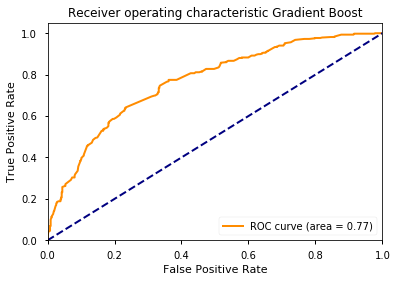

In [62]:
plot_roc(y_test, X_test, model=gb, model_name='Gradient Boost')

## Profit curve

In [51]:
def plot_profit_curve(scoring, profit_matrix, num_points=100):
    x_threshold, y_profit = scoring.profit_curve(num_points=num_points, profit_matrix=profit_matrix)
    
    fig, ax = plt.subplots()
    ax.plot(x_threshold, y_profit)
    
    ymax = max(y_profit)
    xpos = y_profit.index(ymax)
    xmax = x_threshold[xpos]
    
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=180,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction", arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)
    ax.set_ylim(min(y_profit), ymax*2)
    ax.set_xlabel('Threshold For Predicting Fraud')
    ax.set_ylabel('Profit')
    ax.set_title('Profit Curve')
    plt.show()

In [69]:
scoring = evaluation.Scores(model=gb, X_test=X_test, y_test=y_test)
scoring.scores()

Accuracy: 0.7010204081632653
Precision 0.7177914110429447
Recall 0.5379310344827586
F1 0.6149802890932982


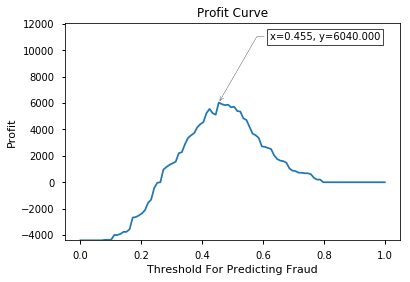

In [70]:
plot_profit_curve(scoring, profit_matrix, num_points=100)